# 💻 Nettverksanalyse i Python

Å finne en korteste vei ved hjelp av et bestemt gate-nettverk er et vanlig GIS-problem
som har mange praktiske applikasjoner. For eksempel, navigasjon, en av de
‘hverdagslige’ applikasjonene der **rute**-algoritmer brukes til å finne den
optimale ruten mellom to eller flere punkter.

Selvfølgelig har Python-økosystemet produsert pakker som kan brukes til
å gjennomføre nettverksanalyser, som for eksempel ruting. 
[NetworkX](https://networkx.github.io/documentation/)-pakken gir forskjellige
verktøy for å analysere nettverk, og implementerer flere forskjellige rutealgoritmer,
som for eksempel
[Dijkstra’s](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html)
eller
[A\*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar)-algoritmene. Begge er vanligvis brukt til å finne korteste veier langs transportnettverk.

For å kunne utføre nettverksanalyse, er det selvfølgelig nødvendig å ha et
nettverk som brukes til analysene. 
[OSMnx](https://osmnx.readthedocs.io/)-pakken lar oss hente rutbare
nettverk fra OpenStreetMap for forskjellige transportformer (gange, sykling og
kjøring). OSMnx-pakken pakker også noen av NetworkX-funksjonene på en praktisk måte
for bruk på OpenStreetMap-data.

I følgende avsnitt vil vi bruke OSMnx til å finne den korteste veien mellom
to punkter basert på sykkelbare veier. Med bare de minste modifikasjonene, kan vi
deretter gjenta analysen for det gangbare gatenettverket.

## Få et rutbart nettverk

For å laste ned OpenStreetMap-data som representerer gatenettverket, kan vi bruke
dens
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)-funksjon. Som parametere forventer den et stedsnavn og, valgfritt, en nettverkstype.

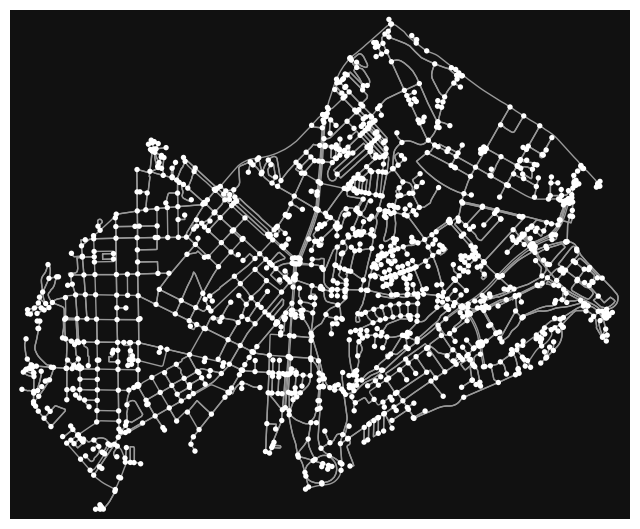

In [1]:
import osmnx

PLACE_NAME = "Grunerløkka, Oslo, Norway"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

:::{admonition} Proft tips!
:class: hint

Noen ganger kan den korteste veien gå litt utenfor det definerte interesseområdet. For å ta hensyn til dette, kan vi hente nettverket for et litt større område
enn Grünerløkka bydel, i tilfelle den korteste veien ikke er helt innenfor
bydelsgrensene. 
:::

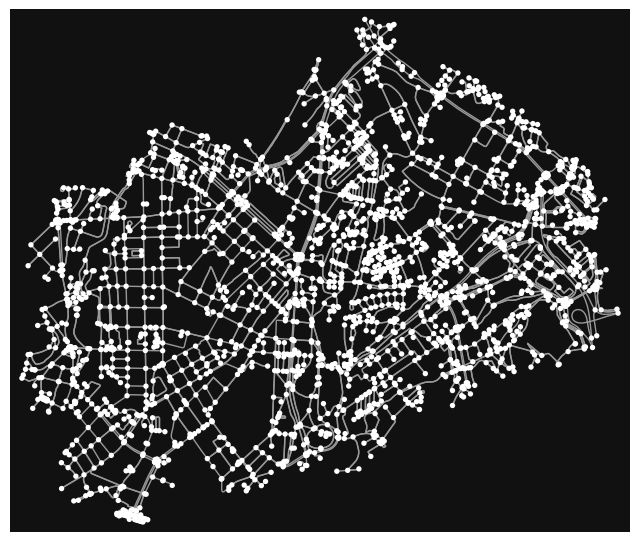

In [2]:
# Få området av interesse polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-projiser polygonet til en lokal projisert CRS (slik at CRS-enheten er meter)
place_polygon = place_polygon.to_crs("EPSG:25833")

# Buffer med 200 meter
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-projiser polygonet tilbake til WGS84 (kreves av OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Hent nettverksgraf
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

### Dataoversikt

Nå som vi har fått et komplett nettverksdiagram for den reisemåten vi spesifiserte
(sykling), kan vi ta en nærmere titt på hvilke attributter som er tildelt
noder og kanter i nettverket. Det er sannsynligvis lettest å først konvertere
nettverket til en geodata-frame der vi deretter kan bruke verktøyene vi lærte i
tidligere leksjoner.

For å konvertere et diagram til en geodata-frame, kan vi bruke `osmnx.graph_to_gdfs()`. Her kan vi gjøre bruk av funksjonens parametere `nodes` og `edges` for å velge om vi vil ha
bare noder, bare kanter, eller begge (standard):

In [3]:
# Hent bare kanter fra grafen
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid  oneway            name        highway  \
u     v          key                                                      
79316 25335244   0       3236576    True      Møllergata   unclassified   
      6945985051 0      39825586   False    Rosteds gate    residential   
      1424670590 0     311012187   False  Hausmanns gate      secondary   
      8714388689 0    1044541319    True             NaN       cycleway   
79317 25389708   0       4854886   False     Wilses gate  living_street   

                     maxspeed reversed   length  \
u     v          key                              
79316 25335244   0         30    False  108.500   
      6945985051 0         30     True   81.266   
      1424670590 0         30     True   31.268   
      8714388689 0        NaN    False   20.933   
79317 25389708   0          8     True   73.470   

                                                               geometry lanes  \
u     v          key                                                            
79316 25335244   0    LINESTRING (10.75135 59.91923, 10.75131 59.919...   NaN   
      6945985051 0    LINESTRING (10.75135 59.91923, 10.75113 59.919...     2   
      1424670590 0    LINESTRING (10.75135 59.91923, 10.75153 59.919...     2   
      8714388689 0    LINESTRING (10.75135 59.91923, 10.75152 59.919...   NaN   
79317 25389708   0    LINESTRING (10.75036 59.91792, 10.75029 59.917...   NaN   

                      ref width tunnel junction bridge service access  
u     v          key                                                   
79316 25335244   0    NaN   NaN    NaN      NaN    NaN     NaN    NaN  
      6945985051 0    NaN   NaN    NaN      NaN    NaN     NaN    NaN  
      1424670590 0    NaN   NaN    NaN      NaN    NaN     NaN    NaN  
      8714388689 0    NaN   NaN    NaN      NaN    NaN     NaN    NaN  
79317 25389708   0    NaN   NaN    NaN      NaN    NaN     NaN    NaN

Den resulterende geodata-framen består av en lang liste med kolonner. De fleste av dem
relaterer til [OpenStreetMap-tags](https://wiki.openstreetmap.org/wiki/Tags), og
navnene deres er ganske selvforklarende. Kolonnene `u` og `v` beskriver
topologisk forhold innen nettverket: de betegner start- og slutt-noden
for hver kant.

:::{list-table} Kolonner i `edges`
:header-rows: 1
:name: columns-in-edges

* - Kolonne
  - Beskrivelse
  - Datatype
* - [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    
  - Broelement              
  - boolean           
* - geometry                                                   
  - Geometri av elementet     
  - Shapely.geometry  
* - [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  
  - Tag for veier (veitype)   
  - str / list        
* - [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      
  - Antall kjørefelt             
  - int (or nan)      
* - [length](http://wiki.openstreetmap.org/wiki/Key:length)    
  - Lengden på elementet (meter)  
  - float             
* - [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)
  - Maksimal lovlige hastighetsbegrensning   
  - int /list         
* - [name](http://wiki.openstreetmap.org/wiki/Key:name)        
  - Navn på (gata) elementet
  - str (or nan)      
* - [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    
  - Enveisvei                
  - boolean           
* - [osmid](http://wiki.openstreetmap.org/wiki/Node)           
  - Unike id-er for elementet  
  - list              
* - [u](http://ow.ly/bV8n30h7Ufm)                              
  - Startnoden for kanten      
  - int               
* - [v](http://ow.ly/bV8n30h7Ufm)                              
  - Sluttnoden for kanten       
  - int               
:::


Hvilke typer gater består nettverket vårt av?

In [4]:
edges["highway"].value_counts()

highway
service                                 1659
residential                             1323
cycleway                                 780
secondary                                347
path                                     302
tertiary                                 287
unclassified                             229
primary                                  166
living_street                             65
pedestrian                                49
trunk                                     37
[service, path]                           32
trunk_link                                27
[cycleway, residential]                   26
[service, residential]                    20
[service, cycleway]                        6
[path, residential]                        4
[service, unclassified]                    4
[cycleway, living_street]                  4
[service, living_street, pedestrian]       2
[service, pedestrian]                      2
[unclassified, residential]                2
[c

### Transformere til projisert referansesystem

Nettverksdataens kartografiske referansesystem (CRS) er WGS84 (EPSG:4326), et
geografisk referansesystem. Det betyr at avstander er registrert og uttrykt
i grader. Dette er ikke praktisk for nettverksanalyser, som for eksempel å finne en korteste vei.

Igjen, OSMnx's *graf*-objekter tilbyr ikke en metode for å transformere deres
geodata, men OSMnx kommer med en separat funksjon:
[`osmnx.project_graph()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph)
tar en inngangsgraf og en CRS som parametere, og returnerer en ny, transformert,
graf. Hvis `crs` utelates, er transformasjonen standard til den mest
egnede UTM-sonen lokalt.

In [5]:
# Transformere grafen til UTM
graph = osmnx.project_graph(graph) 

# Hent re-projiserte noder og kanter
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Analysering av nettverksegenskaper

Nå som vi har forberedt et rutbart nettverksdiagram, kan vi gå over til de mer
analytiske funksjonene til OSMnx, og hente informasjon om nettverket.
For å beregne grunnleggende nettverksegenskaper, bruk
[`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats):

In [6]:
# Beregn nettverksstatistikk
osmnx.basic_stats(graph)

{'n': 2408,
 'm': 5382,
 'k_avg': 4.470099667774086,
 'edge_length_total': 307275.3260000003,
 'edge_length_avg': 57.09314864362696,
 'streets_per_node_avg': 2.5693521594684388,
 'streets_per_node_counts': {0: 0, 1: 651, 2: 22, 3: 1458, 4: 268, 5: 8, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2703488372093023,
  2: 0.009136212624584718,
  3: 0.6054817275747508,
  4: 0.11129568106312292,
  5: 0.0033222591362126247,
  6: 0.0004152823920265781},
 'intersection_count': 1757,
 'street_length_total': 172785.44399999987,
 'street_segment_count': 3025,
 'street_length_avg': 57.11915504132227,
 'circuity_avg': 1.0665293597026342,
 'self_loop_proportion': 0.002644628099173554}

Dette gir oss ennå ikke alle interessante egenskaper ved nettverket vårt, som
OSMnx ikke automatisk tar hensyn til området som er dekket av nettverket.
Vi kan gjøre det manuelt, ved, først, å avgrense nettverkets [convex hull](https://en.wikipedia.org/wiki/Convex_hull) (fra en 'unary'
union av alle funksjonene), og deretter, andre, beregne området av dette skallet.

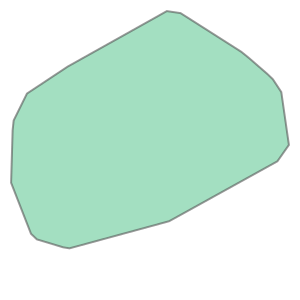

In [7]:
convex_hull = edges.unary_union.convex_hull
convex_hull

In [8]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 2408,
 'm': 5382,
 'k_avg': 4.470099667774086,
 'edge_length_total': 307275.3260000003,
 'edge_length_avg': 57.09314864362696,
 'streets_per_node_avg': 2.5693521594684388,
 'streets_per_node_counts': {0: 0, 1: 651, 2: 22, 3: 1458, 4: 268, 5: 8, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2703488372093023,
  2: 0.009136212624584718,
  3: 0.6054817275747508,
  4: 0.11129568106312292,
  5: 0.0033222591362126247,
  6: 0.0004152823920265781},
 'intersection_count': 1757,
 'street_length_total': 172785.44399999987,
 'street_segment_count': 3025,
 'street_length_avg': 57.11915504132227,
 'circuity_avg': 1.0665293597026342,
 'self_loop_proportion': 0.002644628099173554,
 'node_density_km': 320.1069230694339,
 'intersection_density_km': 233.56638863496485,
 'edge_density_km': 40847.57439411018,
 'street_density_km': 22969.193035725057}

In [9]:
import math
import myst_nb

myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

320.1

307

Som vi kan se, har vi nå mye informasjon om gatenettverket vårt som
kan brukes til å forstå strukturen. Vi kan for eksempel se at gjennomsnittlig
nodetetthet i nettverket vårt er {glue:}`node_density_km`&nbsp;noder/km og at
den totale kantlengden på nettverket vårt er mer enn
{glue:}`edge_length_total`&nbsp;kilometer.



---


## Korteste vei-analyse

La oss nå beregne den korteste veien mellom to punkter ved hjelp av
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).



### Opprinnelses- og destinasjonspunkter 

Først må vi spesifisere opprinnelses- og destinasjonspunkter for ruten vår. Hvis du
er kjent med Grünerløkka-området, kan du spesifisere et egendefinert stedsnavn som en
kildeposisjon. Eller, du kan følge med og velge disse punktene som opprinnelse
og destinasjon i analysen:
- [`Trondheimsveien 110 C, Oslo, Norway`](https://nominatim.openstreetmap.org/ui/search.html?q=Trondheimsveien+110+C):
  Carl Berner-krysset.
- [`Grünerhagen`](https://nominatim.openstreetmap.org/ui/search.html?q=Gr%C3%BCnerhagen),
  en park nederst på Løkka.

Vi kunne finne ut koordinatene for disse stedene manuelt, og lage
`shapely.geometry.Point`s basert på koordinatene. Men hvis vi ville ha
mer enn bare to punkter, ville det raskt bli et ork. I stedet kan vi
bruke OSMnx til å geokode lokasjonene.

Husk å transformere opprinnelses- og destinasjonspunktene til samme referanse
system som nettverksdataene.

In [10]:
origin = (
    osmnx.geocode_to_gdf("Trondheimsveien 110 C, Oslo, Norway", which_result=1)  # hent geolokasjon
    .to_crs(edges.crs)  # transformer til UTM
    .at[0, "geometry"]  # velg geometri av første rad
)

destination = (
    osmnx.geocode_to_gdf("Grünerhagen")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

Vi har nå `shapely.geometry.Point`s som representerer opprinnelses- og destinasjon
plasseringene for nettverksanalysen vår. I en neste trinn, må vi finne disse punktene på
det rutbare nettverket før den endelige rutingen.

### Nærmeste node

For å rute på nettverket, må vi først finne et startpunkt og sluttpunkt
som er en del av nettverket. Bruk
[`osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes)
for å returnere den nærmeste nodens ID:

In [11]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

832779407

In [12]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

16193897

### Ruting

Nå er vi klare for ruting og for å finne den korteste veien mellom
opprinnelses- og målplasseringene. Vi vil bruke
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

Funksjonen tar tre obligatoriske parametere: en graf, en opprinnelsesnod-id, og
en destinasjonsnod-id, og to valgfrie parametere: `weight` kan settes til
å vurdere en annen *kostnadsimpedans* enn lengden på ruten, og `cpus`
kontrollerer parallell beregning av mange ruter.

In [13]:
# Finn den korteste veien mellom opprinnelse og destinasjon
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[832779407,
 2481252143,
 841832182,
 12534265,
 79607,
 330463916,
 79605,
 106138,
 5580791789,
 10973871838,
 4618464230,
 12534258,
 4618464227,
 1387802061,
 1426810245,
 106168,
 106141,
 106169,
 106171,
 837970612,
 10178369286,
 16193897]

Som et resultat får vi en liste over alle nodene som er langs den korteste veien.

Vi kunne hente plasseringene til disse nodene fra `nodes`
GeoDataFramen og lage en LineString-presentasjon av punktene, men heldigvis,
OSMnx kan gjøre det for oss og vi kan plotte korteste vei ved hjelp av
`plot_graph_route()`-funksjonen:

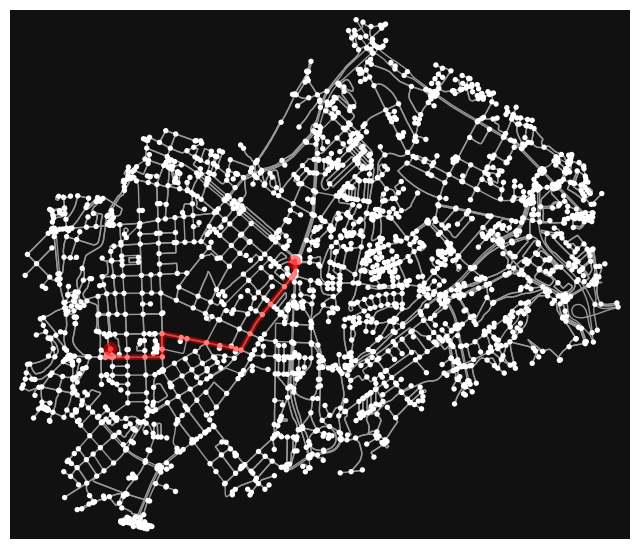

In [14]:
# Plot den korteste veien
fig, ax = osmnx.plot_graph_route(graph, route)

Flott! Nå har vi den korteste veien mellom opprinnelses- og målplasseringene våre.
Å kunne analysere korteste veier mellom steder kan være verdifull
informasjon for mange applikasjoner. Her analyserte vi bare de korteste veiene
basert på avstand, men ganske ofte er det mer nyttig å finne de optimale rutene
mellom steder basert på reisetiden. Her, for eksempel kunne vi
beregne tiden det tar å krysse hvert veisegment ved å dele
lengden på veisegmentet med fartsgrensen og beregne de optimale
rutene ved å ta hensyn til fartsgrensene også som kan endre
resultatet spesielt på lengre turer enn her.

## Lagre korteste veier til disk

Ganske ofte må du lagre ruten til en fil for videre analyse og
visualiseringsformål, eller i det minste ha den som et GeoDataFrame-objekt i Python.
La oss derfor fortsette litt til og se hvordan vi kan lage ruten til en
linjestreng og lagre den korteste veigeometrien og relaterte attributter i en
geopackage-fil.

Først må vi få nodene som tilhører den korteste veien:

In [15]:
# Få nodene langs den korteste veien
route_nodes = nodes.loc[route]
route_nodes

,y,x,highway,street_count,lon,lat,ref,geometry
osmid,,,,,,,,
832779407,6.644504e+06,599257.916763,NaN,3,10.775706,59.926021,NaN,POINT (599257.917 6644503.528)
2481252143,6.644431e+06,599258.760391,NaN,4,10.775686,59.925368,NaN,POINT (599258.760 6644430.804)
841832182,6.644408e+06,599241.069524,NaN,3,10.775359,59.925170,NaN,POINT (599241.070 6644408.291)
12534265,6.644354e+06,599198.726208,NaN,3,10.774576,59.924697,NaN,POINT (599198.726 6644354.409)
79607,6.644248e+06,599114.681136,NaN,3,10.773023,59.923766,NaN,POINT (599114.681 6644248.447)
330463916,6.644186e+06,599065.091608,NaN,3,10.772106,59.923213,NaN,POINT (599065.092 6644185.549)
79605,6.644070e+06,598990.718616,traffic_signals,4,10.770721,59.922193,NaN,POINT (598990.719 6644069.855)
106138,6.643971e+06,598936.431294,NaN,4,10.769704,59.921318,NaN,POINT (598936.431 6643970.977)
5580791789,6.643978e+06,598905.840513,NaN,3,10.769160,59.921385,NaN,POINT (598905.841 6643977.636)


Som vi kan se, har vi nå alle nodene som var en del av den korteste veien som en GeoDataFrame.

Nå kan vi lage en LineString ut av punktgeometriene til nodene:

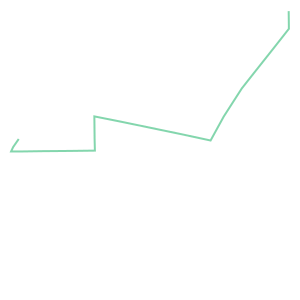

In [16]:
import shapely.geometry

# Lag en geometri for den korteste veien
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Nå har vi ruten som en LineString-geometri.

La oss lage en GeoDataFrame ut av den med litt nyttig informasjon om ruten vår,
for eksempel en liste over osm-idene som er en del av ruten og lengden
på ruten.

In [17]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Beregn rute-lengden
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (599257.917 6644503.528, 599258.760...","[832779407, 2481252143, 841832182, 12534265, 7...",1669.84232


Nå har vi en GeoDataFrame som vi kan lagre til disk. La oss fortsatt bekrefte at
alt er ok ved å plotte ruten vår på toppen av gatenettverket og noen
bygninger, og plot også opprinnelses- og målpunktene på toppen av kartet vårt.

Last ned bygninger:

In [18]:
bygninger = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

La oss nå plotte ruten og gatenettverkselementene for å bekrefte at
alt er som det skal:

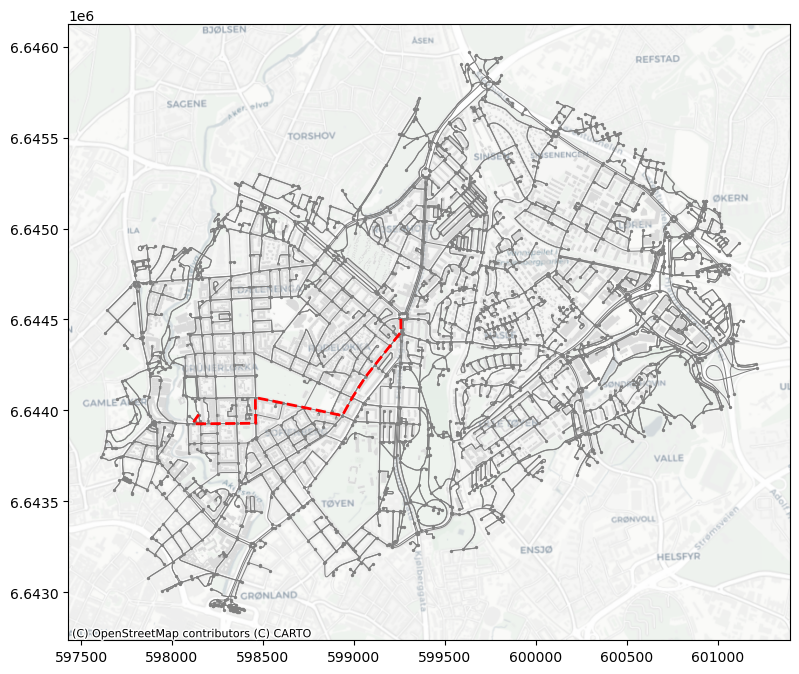

In [19]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot kanter og noder
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Legg til bygninger
ax = bygninger.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Legg til ruten
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Legg til bakgrunnskart
contextily.add_basemap(ax, crs=bygninger.crs, source=contextily.providers.CartoDB.Positron)

Flott, alt ser ut til å være i orden! Som du kan se, har vi nå full
kontroll over alle elementene i kartet vårt, og vi kan bruke alle estetiske
egenskaper som matplotlib gir for å endre hvordan kartet vårt vil se ut. Nå
er vi nesten klare til å lagre dataene våre på disk.



## Forbered data for lagring til fil

Dataene inneholder visse datatyper (som `list`) som bør konverteres
til tegnstrenger før du lagrer dataene til fil (et alternativ ville være
å droppe ugyldige kolonner).

In [20]:
edges.head()

osmid  oneway            name       highway  \
u        v          key                                                     
79316    25335244   0       3236576    True      Møllergata  unclassified   
         6945985051 0      39825586   False    Rosteds gate   residential   
         1424670590 0     311012187   False  Hausmanns gate     secondary   
         8714388689 0    1044541319    True             NaN      cycleway   
25335244 79317      0       3236576    True      Møllergata  unclassified   

                        maxspeed reversed   length  \
u        v          key                              
79316    25335244   0         30    False  108.500   
         6945985051 0         30     True   81.266   
         1424670590 0         30     True   31.268   
         8714388689 0        NaN    False   20.933   
25335244 79317      0         30    False   47.137   

                                                                  geometry  \
u        v          key                                                      
79316    25335244   0    LINESTRING (597916.667 6643710.788, 597914.829...   
         6945985051 0    LINESTRING (597916.667 6643710.788, 597904.519...   
         1424670590 0    LINESTRING (597916.667 6643710.788, 597926.961...   
         8714388689 0    LINESTRING (597916.667 6643710.788, 597926.099...   
25335244 79317      0    LINESTRING (597882.414 6643608.012, 597877.956...   

                        lanes tunnel junction  ref width bridge service access  
u        v          key                                                         
79316    25335244   0     NaN    NaN      NaN  NaN   NaN    NaN     NaN    NaN  
         6945985051 0       2    NaN      NaN  NaN   NaN    NaN     NaN    NaN  
         1424670590 0       2    NaN      NaN  NaN   NaN    NaN     NaN    NaN  
         8714388689 0     NaN    NaN      NaN  NaN   NaN    NaN     NaN    NaN  
25335244 79317      0     NaN    NaN      NaN  NaN   NaN    NaN     NaN    NaN

In [21]:
# Kolonner med ugyldige verdier
problematiske_kolonner = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
]

#  konverter valgte kolonner til strengformat
edges[problematiske_kolonner] = edges[problematiske_kolonner].to_string()

In [22]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

In [23]:
print(edges.dtypes)

osmid         object
oneway          bool
name          object
highway       object
maxspeed      object
reversed      object
length       float64
geometry    geometry
lanes         object
tunnel        object
junction      object
ref           object
width         object
bridge        object
service       object
access        object
dtype: object


Nå kan vi se at de fleste attributtene er av typen `object` som ganske ofte (som vår her) refererer til en datatypetype.

## Lagre dataene:

In [24]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

Avhengig av hvor stort interesseområde vi har definert, så kan denne filen bli veldig stor, derfor lagrer vi bare ruten i denne omgang:

In [26]:
# Lagre ett lag etter et annet
output_gpkg = DATA_MAPPE / "osm_data"/ "OSM_Grunerlokka.gpkg"
#edges = edges[["osmid","name","highway","maxspeed","length","geometry","width"]]
#edges.to_file(output_gpkg, layer="streets")
route_geom.to_file(output_gpkg, layer="route")
#nodes.to_file(output_gpkg, layer="nodes")
#bygninger[['geometry', 'name', 'addr:street']].to_file(output_gpkg, layer="buildings")
display(bygninger.describe())
display(bygninger)

,geometry,wheelchair,bicycle,foot,access,amenity,capacity,fee,layer,name,...,ref,advertising,mapillary,name:signed,substation,man_made,craft,ways,type,location
count,3674,14,1,1,3,32,5,5,13,82,...,1,1,1,1,1,4,1,16,16,3
unique,3674,3,1,1,2,14,4,2,3,80,...,1,1,1,1,1,2,1,16,1,1
top,"POLYGON ((598274.6568148177 6644245.449987558,...",limited,yes,yes,private,place_of_worship,500,no,1,Kunsthøgskolen i Oslo,...,1735,board,293938462404822,no,minor_distribution,silo,yes,"[133363272, 112236630]",multipolygon,indoor
freq,1,6,1,1,2,10,2,3,10,2,...,1,1,1,1,1,3,1,1,16,3


geometry  \
element_type osmid                                                         
way          9334580   POLYGON ((599664.327 6645572.202, 599700.091 6...   
             27011865  POLYGON ((599021.107 6643847.082, 599007.188 6...   
             27011866  POLYGON ((599096.358 6643849.709, 599075.963 6...   
             27011867  POLYGON ((599103.169 6643631.899, 599088.901 6...   
             27011868  POLYGON ((599012.323 6643681.946, 599011.947 6...   
...                                                                  ...   
relation     13803840  POLYGON ((597928.252 6644296.877, 597927.103 6...   
             13803841  POLYGON ((598151.179 6643166.871, 598163.554 6...   
             15885246  POLYGON ((600151.857 6643897.110, 600142.549 6...   
             15896730  POLYGON ((600162.955 6645115.376, 600163.099 6...   
             15896731  POLYGON ((600118.937 6645122.072, 600155.178 6...   

                      wheelchair bicycle foot access amenity capacity  fee  \
element_type osmid                                                           
way          9334580         NaN     NaN  NaN    NaN     NaN      NaN  NaN   
             27011865    limited     NaN  NaN    NaN     NaN      NaN  yes   
             27011866    limited     NaN  NaN    NaN     NaN      NaN  yes   
             27011867    limited     NaN  NaN    NaN     NaN      NaN  NaN   
             27011868        NaN     NaN  NaN    NaN     NaN      NaN  NaN   
...                          ...     ...  ...    ...     ...      ...  ...   
relation     13803840        NaN     NaN  NaN    NaN     NaN      NaN  NaN   
             13803841        NaN     NaN  NaN    NaN     NaN      NaN  NaN   
             15885246        NaN     NaN  NaN    NaN     NaN      NaN  NaN   
             15896730        NaN     NaN  NaN    NaN     NaN      NaN  NaN   
             15896731        NaN     NaN  NaN    NaN     NaN      NaN  NaN   

                      layer              name  ...  ref advertising mapillary  \
element_type osmid                             ...                              
way          9334580    NaN               NaN  ...  NaN         NaN       NaN   
             27011865   NaN  Zoologisk museum  ...  NaN         NaN       NaN   
             27011866   NaN  Geologisk museum  ...  NaN         NaN       NaN   
             27011867   NaN          Lids hus  ...  NaN         NaN       NaN   
             27011868   NaN               NaN  ...  NaN         NaN       NaN   
...                     ...               ...  ...  ...         ...       ...   
relation     13803840   NaN               NaN  ...  NaN         NaN       NaN   
             13803841   NaN               NaN  ...  NaN         NaN       NaN   
             15885246   NaN               NaN  ...  NaN         NaN       NaN   
             15896730   NaN               NaN  ...  NaN         NaN       NaN   
             15896731   NaN               NaN  ...  NaN         NaN       NaN   

                      name:signed substation man_made craft  \
element_type osmid                                            
way          9334580          NaN        NaN      NaN   NaN   
             27011865         NaN        NaN      NaN   NaN   
             27011866         NaN        NaN      NaN   NaN   
             27011867         NaN        NaN      NaN   NaN   
             27011868         NaN        NaN      NaN   NaN   
...                           ...        ...      ...   ...   
relation     13803840         NaN        NaN      NaN   NaN   
             13803841         NaN        NaN      NaN   NaN   
             15885246         NaN        NaN      NaN   NaN   
             15896730         NaN        NaN      NaN   NaN   
             15896731         NaN        NaN      NaN   NaN   

                                                      ways          type  \
element_type osmid                                                         
way          9334580              

Flott, nå har vi lagret alle dataene som ble brukt til å produsere kartene i en geopakke.



## Videre lesing

Her lærte vi hvordan man løser en enkel ruteoppgave mellom opprinnelses- og målpunkt. Hva om vi har hundrevis eller tusenvis av opprinnelser? Dette er tilfelle hvis du vil utforske reiseavstandene til en spesifikk plassering over hele byen, for eksempel når du analyserer tilgjengeligheten av jobber og tjenester (som i reisetidsmatrisedataene som ble brukt i tidligere seksjoner). 

Sjekk ut pyrosm-dokumentasjonen om [arbeid med grafer](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs) for mer avanserte eksempler på nettverksanalyse i python. For eksempel er [pandana](https://udst.github.io/pandana/) et raskt og effektivt python-bibliotek for å lage aggregerte nettverksanalyser på kort tid over store nettverk, og pyrosm kan brukes til å forberede inngangsdataene for en slik analyse.